In [2]:
import pandas as pd # data cleaning
from sklearn.metrics import accuracy_score # for accuracy of test data
from sklearn.metrics import precision_recall_fscore_support # further classification metrics
from sklearn.model_selection import train_test_split # how to properly split the data into train and test set
import string # test preprocessing
import nltk # Explained Below
from nltk.corpus import stopwords # Explained Below
import matplotlib.pyplot as plt # graphing relevant objects

### Blog Link:
https://www.blogger.com/u/0/blog/post/edit/6047707090945020095/7517903866570529982?hl=en

### How to Reproduce the Code: 

This code is being run on my own personal laptop. All code below is reproducible and should run with no issues. The dataset link is pasted below in the "Dataset" section. The dataset consists of two downloadable files with one file containing real news and the other containing fake news.  

### Introduction:

Fake news is a term which describes fabricated or deliberately misleading information presented as factual news. Fake news is prominent on many social media platforms, such as Twitter and Facebook. Many serious issues can arise with the dissemination of fake news, such as the spreading of misinformation of sensitive subjects, influencing public opinion, and even generating false narratives of specific communities. It is imperative for the detection of factual versus fake news to ensure the correct information is being spread since the safety of groups can be compromised.

In this paper, we will implement several different machine learning algorithms on the University of Victoria's, School of Engineering, Fake News dataset \cite{b1}. This dataset is comprised of nearly 45,000 news articles. After training and testing each model, we will compare their performance and select the most accurate one for further analysis. This analysis will involve examining the features and patterns that the model has identified as necessary for fake news article detection. 

### Dataset: 

The dataset contains real and fake news articles. This dataset was collected from realworld sources; the truthful articles were obtained by crawling articles from Reuters.com (News website). As for the fake news articles, they were collected from different sources. The fake news articles were collected from unreliable websites that were flagged by Politifact (a fact-checking organization in the USA) and Wikipedia. The dataset contains different types of articles on different
topics, however, the majority of articles focus on political and World news topics. 

https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/

In [3]:
df_fake = pd.read_csv('Fake.csv')
df_real = pd.read_csv('True.csv')

### Viewing the Data:

First, we will view the fake and factual news data. We can see below that there are four features: "Title", "Text", "Subject" and "Date". The title column represents the title of the article, the text contains the text of the article, the subject is a brief overview of what subject the news category is in, and the date is when the article was posted. 

In [4]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Create Labels: 

Here, we will assign labels to the data. A binary classification model will be used to detect the news articles. A '1' represents fake news and a '0' represents the real new articles. 

In [15]:
df_fake["class"] = 1
df_real["class"] = 0

### Size of data: 

The fake news has 23,481 entries with 5 columns (including the label column). The real news has 21,417 entries with the same columns. 

In [20]:
df_fake.shape, df_real.shape

((23481, 5), (21417, 5))

### Merge the Data:

In this section we will concatenate both dataframes to create one singular dataframe. The name of the new dataframe is 'df_full'. The data is further cleaned to drop duplicate entries as well values that are non-existent. After cleaning the data, 209 entries were removed from the new dataframe. The merged dataframe has 44,689 entries and 5 features. 

In [21]:
df_full = pd.concat([df_fake, df_real])
df_full.drop_duplicates(inplace = True) 
df_full.dropna(axis=0, inplace = True) 
df_full.head()
df_full.shape

(44689, 5)

### Balance the Dataframe:

In this code chunk below, we are balancing the dataframes so that there are an equal amount of real and fake news articles. Although the dataset was already fairly balanced, this will ensure a 50/50 balance among the entries for the future classifiers. 

In [22]:
# Separate the fake and real data
df_fake_balanced = df_full[df_full['class'] == 0]
df_real_balanced = df_full[df_full['class'] == 1]

min_class_size = min(len(df_fake_balanced), len(df_real_balanced))

# Randomly sample the same number of entries from each class
df_fake_balanced = df_fake_balanced.sample(n=min_class_size, random_state=42)
df_real_balanced = df_real_balanced.sample(n=min_class_size, random_state=42)

df_full_balanced = pd.concat([df_fake_balanced, df_real_balanced])

# Reset the index
df_full_balanced.reset_index(drop=True, inplace=True)

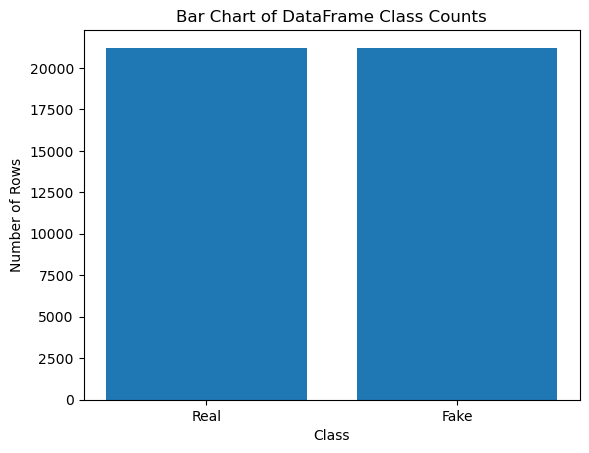

In [25]:
class_labels = {1: 'Fake', 0: 'Real'}
df_full_balanced['class_label'] = df_full_balanced['class'].map(class_labels)

# Count occurrences of each class
class_counts = df_full_balanced['class_label'].value_counts()

# Create the bar chart
fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts.values)
ax.set_title('Bar Chart of DataFrame Class Counts')
ax.set_ylabel('Number of Rows')
ax.set_xlabel('Class')

plt.show()

### Continue Cleaning: 

For this project, we  are only interested in the "text" column of the dataset since this is where most of the false information is stored. We drop the title, subject, and date features from the dataset and keep the text and label column. The label column denotes if the article is fake or factual. The dataframe is once again renamed to 'data'. 

In [27]:
data = df_full_balanced.drop(['title', 'subject', 'date'], axis = 1)
data.head()

,text,class,class_label
0,JERUSALEM/BEIRUT (Reuters) - Five projectiles ...,0,Real
1,BEIRUT (Reuters) - Russia s planned peace talk...,0,Real
2,TAIPEI (Reuters) - Taiwan and China need to dr...,0,Real
3,WASHINGTON (Reuters) - Aides to President-elec...,0,Real
4,ISTANBUL (Reuters) - Turkey s Deputy Prime Min...,0,Real


### Viewing the dataframe: 

The following two code chunks show the cleaned dataframe, and some samples from the dataframe. We can see that there are real news and fake news labels present in the sample below. The following code chunk resets the index which randomly shuffles the dataframe. 

In [28]:
data = data.sample(frac = 1)
data.head()

,text,class,class_label
32290,"When major changes happen, it is often difficu...",1,Fake
39404,Donald Trump is an unapologetic Islamophobic b...,1,Fake
8176,(Reuters) - United Nations aid agencies said t...,0,Real
35212,Conservatives may have the nominee they wanted...,1,Fake
1137,PARIS (Reuters) - French voters view far lefti...,0,Real


In [29]:
data.reset_index(inplace = True)
data.drop(['index'], axis = 1, inplace = True)
data.columns
data.head()

,text,class,class_label
0,"When major changes happen, it is often difficu...",1,Fake
1,Donald Trump is an unapologetic Islamophobic b...,1,Fake
2,(Reuters) - United Nations aid agencies said t...,0,Real
3,Conservatives may have the nominee they wanted...,1,Fake
4,PARIS (Reuters) - French voters view far lefti...,0,Real


### NLTK Stopwords: 

Stopwords are common 'filler' words in the english language. They are known to add noise to articles and must be removed from the text of the articles in order to perform the proper analysis. This is a must for text pre-processing. 

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kylestein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Text Pre-processing: 

Here, we are taking the text feature as a string input and applying some text operations to it. We first remove all punctuation marks from the text and form a new string with no punctuation marks. Then we split the strings into individual words and remove the stopwords using the NLTK stopwords function. This process helps improve the natural language processing technique for the machine learning algorithm.

In [31]:
def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    return clean_words

In [32]:
data['text'].head().apply(process_text)

0    [major, changes, happen, often, difficult, rea...
1    [Donald, Trump, unapologetic, Islamophobic, bi...
2    [Reuters, United, Nations, aid, agencies, said...
3    [Conservatives, may, nominee, wanted, killed, ...
4    [PARIS, Reuters, French, voters, view, far, le...
Name: text, dtype: object

In [33]:
data['text']

0        When major changes happen, it is often difficu...
1        Donald Trump is an unapologetic Islamophobic b...
2        (Reuters) - United Nations aid agencies said t...
3        Conservatives may have the nominee they wanted...
4        PARIS (Reuters) - French voters view far lefti...
                               ...                        
42417    According to The Washington Post, sources clos...
42418    21st Century Wire says We ve said it many time...
42419    BUENOS AIRES (Reuters) - Argentina s main labo...
42420    How are nonwhite children supposed to feel saf...
42421    Every website has a 404 page that you land on ...
Name: text, Length: 42422, dtype: object

### Train-Test Split using Scikit Learn:

In this section, we split the train and test data as a necessary pre-processing technique for input into the machine learning algorithm. 'X' represents the cleaned text of the article and 'y' represents the "real = 1" or "fake = 0" labels for the articles. The dataframe is split into 70% for training and 30% for testing. The training size consists of 29,695 articles and the testing size contains 12,727 articles. 

In [34]:
X = data['text']
y = data['class']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("Training Size", X_train.shape) 
print("Testing Size", X_test.shape)

Training Size (29695,)
Testing Size (12727,)


### Vectorize the Text Data:

The purpose of vectorizing the text data is to convert the text data into numerical represenation so the machine learning model can understand. Below, we are using the TF-IDF (Term frequency-inverse document frequency) vectorizer. The TF-IDF essentially calculates the importance of a word in each article. Term frequency calculates how many times a word is used in a document, while document frequency shows the number of articles containing a specific term. 

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()
x1_train = vectorization.fit_transform(X_train)
x1_test = vectorization.transform(X_test)

### Logistic Regression:

Logistic regression is being utilized in this project to train the model for binary classification. Logistic regression assigns a probability value between 0 and 1 of if the article is either factual or false. A probability score of under 0.5 will be assigned as a 0 and values of over 0.5 will be assigned a 1. 


In [37]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(x1_train, y_train)

LogisticRegression()

### Predictive Outcome for Logistic Regression:

Below, we can see the results from our analysis. We have correctly predicted 98.6% of the real versus fake news articles of the test dataset. This proves that the method was effective predicting the outcomes on the test dataset.

In [38]:
pred_lr = LR.predict(x1_test)

In [39]:
print('Misclassified examples: %d' % (y_test != pred_lr).sum())

Misclassified examples: 177


In [40]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, pred_lr)) #test accuracy

Logistic Regression Accuracy: 0.986092559126267


### Misclassified Indices: 

Below is the vector of all indices that are misclassified. We could go back into the dataset to observe which articles are misclassified (total of 177 indices).

In [41]:
misclassified = (pred_lr != y_test)
print("Misclassified Examples Indices:", [i for i, x in enumerate(misclassified) if x])

Misclassified Examples Indices: [71, 82, 176, 208, 300, 382, 397, 447, 563, 759, 980, 1211, 1227, 1240, 1334, 1419, 1427, 1557, 1567, 1628, 1709, 1750, 1793, 1816, 1837, 1907, 2104, 2181, 2187, 2193, 2201, 2242, 2280, 2311, 2358, 2519, 2595, 2621, 2865, 2878, 2921, 2962, 3008, 3048, 3421, 3453, 3538, 3543, 3562, 3576, 3580, 3768, 3822, 3823, 3852, 3891, 3901, 3960, 3982, 4080, 4087, 4141, 4152, 4159, 4245, 4255, 4289, 4622, 4729, 4916, 4925, 5013, 5182, 5307, 5442, 5474, 5572, 5652, 5668, 5683, 5898, 5927, 5930, 6030, 6075, 6147, 6213, 6238, 6240, 6242, 6356, 6504, 6630, 6638, 6683, 6822, 6868, 6907, 6934, 7183, 7226, 7323, 7444, 7556, 7584, 7613, 7628, 7639, 7696, 7743, 7818, 7856, 7864, 7870, 7986, 8000, 8009, 8039, 8082, 8085, 8100, 8102, 8117, 8178, 8201, 8225, 8287, 8430, 8502, 8504, 8585, 8768, 8770, 9093, 9222, 9311, 9402, 9415, 9428, 9435, 9582, 9583, 9630, 9678, 9755, 9809, 9879, 9929, 10013, 10017, 10210, 10244, 10319, 10322, 10444, 10503, 10514, 10768, 10782, 10896, 11020, 1

### Precision, Recall, F1-Score for Logistic Regression:

Precision, recall, and F1-score are common evaluation methods when it comes to analyzing the machine learning models. Below, we can observe that the precision, recall, and f1-score of  both classes were extremely high, which is a great indicator that our data is being correctly classified. 


In [42]:
print("Precision, Recall, Fscore:", precision_recall_fscore_support(y_test, pred_lr, average='binary'))

Precision, Recall, Fscore: (0.9873797128884683, 0.9847388294524858, 0.986057502953919, None)


### Support Vector Machines: 

Below, we will also implement a Support Vector Machine (SVM) to the data to train the model and produce results. The SVM finds the optimal hyperplane that best seperates the data into their respective predicted classes. We will set the C paramter to 1.0 which helps maximize the margin while minimizing the classification error. The random state will be set to 1 to ensure reproducible results. 

In [43]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(x1_train, y_train)

SVC(kernel='linear', random_state=1)

### Predictive Outcome for Support Vector Machines:

Below, we can see the results from our analysis. We have correctly predicted 99.3% of the real versus fake news articles of the test dataset. This proves that the method was effective predicting the outcomes on the test dataset.

In [44]:
pred_svm = svm.predict(x1_test)

In [45]:
print('Misclassified examples: %d' % (y_test != pred_svm).sum())

Misclassified examples: 84


In [46]:
print("Support Vector Machine Accuracy:", accuracy_score(y_test, pred_svm)) #test accuracy

Support Vector Machine Accuracy: 0.9933998585683979


### Misclassified Indices: 

Below is the vector of all indices that are misclassified. We could go back into the dataset to observe which articles are misclassified (total of 84 indices).

In [47]:
misclassified = (pred_svm != y_test)
print("Misclassified Examples Indices:", [i for i, x in enumerate(misclassified) if x])

Misclassified Examples Indices: [82, 422, 447, 563, 759, 848, 1334, 1427, 1628, 1750, 1793, 1816, 1907, 2181, 2187, 2201, 2242, 2519, 2595, 2677, 2962, 3048, 3453, 3543, 3576, 3580, 3822, 3823, 3852, 3901, 4080, 4152, 4319, 4622, 5135, 5442, 5661, 5683, 5927, 6048, 6075, 6147, 6213, 6356, 6934, 7183, 7226, 7323, 7444, 7449, 7613, 7856, 7864, 7870, 8117, 8178, 8225, 8286, 8430, 8502, 8504, 9311, 9402, 9428, 9583, 9678, 9755, 10013, 10085, 10210, 10244, 10322, 10436, 10514, 10768, 11020, 11201, 11283, 11448, 11642, 11894, 11962, 12047, 12207]


### Precision, Recall, F1-Score for Support Vector Machine:

Precision, recall, and F1-score are common evaluation methods when it comes to analyzing the machine learning models. Below, we can observe that the precision, recall, and f1-score of both classes were extremely high, which is a great indicator that our data is being correctly classified. 

In [48]:
print("Precision, Recall, Fscore:", precision_recall_fscore_support(y_test, pred_svm, average='binary'))

Precision, Recall, Fscore: (0.9938582677165354, 0.9929200755191945, 0.993388950102314, None)


### Decision Tree Classifiers: 

Below, we will also implement a decision tree classifier to the data to train the model and produce results. A decision  builds a tree-like model by splitting the training data into subsets based on the most informative features, leading to a set of simple decision rules to classify articles.

In [49]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)
dt.fit(x1_train, y_train)
pred_dt = dt.predict(x1_test)

In [50]:
print('Misclassified examples: %d' % (y_test != pred_dt).sum())
print("Decision Tree Accuracy:", accuracy_score(y_test, pred_dt))
print("Precision, Recall, Fscore:", precision_recall_fscore_support(y_test, pred_dt, average='binary'))

Misclassified examples: 60
Decision Tree Accuracy: 0.9952856132631414
Precision, Recall, Fscore: (0.9955919395465995, 0.9949653870358716, 0.9952785646836638, None)


### Random Forest Classifier: 

The random forest classifier is an  method that constructs multiple decision trees and combines their predictions. This approach generally results in better performance and robustness.

In [51]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(x1_train, y_train)
pred_rf = rf.predict(x1_test)

In [52]:
print('Misclassified examples: %d' % (y_test != pred_rf).sum())
print("Random Forest Accuracy:", accuracy_score(y_test, pred_rf))
print("Precision, Recall, Fscore:", precision_recall_fscore_support(y_test, pred_rf, average='binary'))

Misclassified examples: 131
Random Forest Accuracy: 0.989706922291192
Precision, Recall, Fscore: (0.991783852109338, 0.9875707992448081, 0.9896728419392984, None)


### Gradient Boosting Classifier

Gradient boosting machines are another type of  model that builds decision trees to minimize the residual errors from previous trees. 

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators=100, random_state=1)
gbm.fit(x1_train, y_train)
pred_gbm = gbm.predict(x1_test)

In [54]:
print('Misclassified examples: %d' % (y_test != pred_gbm).sum())
print("Gradient Boosting Machine Accuracy:", accuracy_score(y_test, pred_gbm))
print("Precision, Recall, Fscore:", precision_recall_fscore_support(y_test, pred_gbm, average='binary'))

Misclassified examples: 60
Gradient Boosting Machine Accuracy: 0.9952856132631414
Precision, Recall, Fscore: (0.9982589427033871, 0.9922907488986784, 0.995265898690232, None)


### ROC Curves

In [55]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [56]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 0.2, 0.8, 1])  # Adjust axis limits here
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

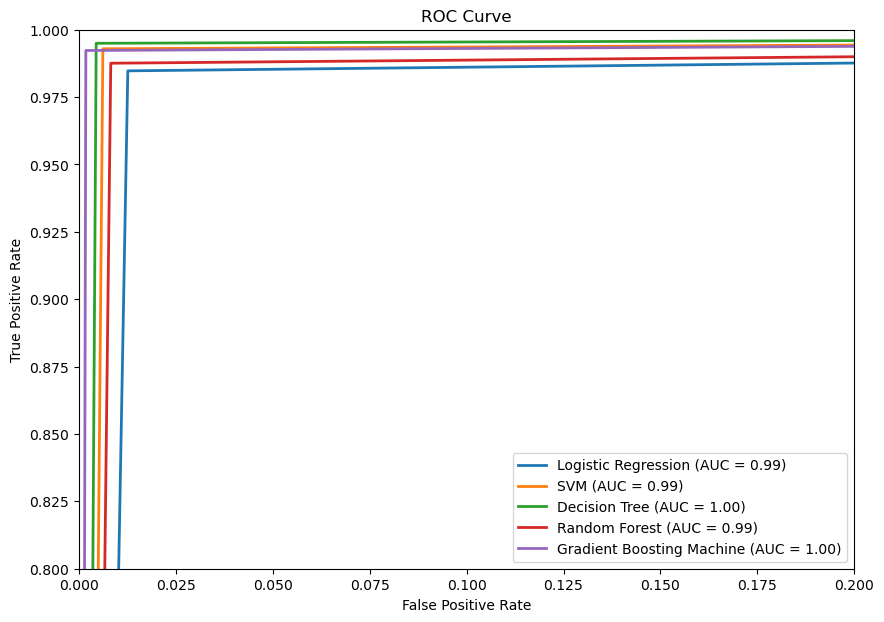

In [60]:
# Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Support Vector Machine
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Decision Tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Gradient Boosting Machine
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_test, pred_gbm)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plot_roc_curve(fpr_lr, tpr_lr, "Logistic Regression (AUC = %0.2f)" % roc_auc_lr)
plot_roc_curve(fpr_svm, tpr_svm, "SVM (AUC = %0.2f)" % roc_auc_svm)
plot_roc_curve(fpr_dt, tpr_dt, "Decision Tree (AUC = %0.2f)" % roc_auc_dt)
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest (AUC = %0.2f)" % roc_auc_rf)
plot_roc_curve(fpr_gbm, tpr_gbm, "Gradient Boosting Machine (AUC = %0.2f)" % roc_auc_gbm)
plt.legend(loc="lower right")
plt.show()


The ROC (Receiving Operating Characteristic) curve helps illustrate the performance of each binary classification model. The ROC curve plots the true positive rate against the false positive rate of the rsults for each model. The ROC curves for each model show near perfect classification for each model that was tested. 

### Table Comparison: 

Classifier | Accuracy | Precision | Recall | F-Score | Misclassified Examples |
-----|-----|-----|-----|-----|----- 
Logistic Regression | 98.61 | 98.74 | 98.47 | 98.61 | 177 |
SVM | 99.34 | 99.39 | 99.29 | 99.34 | 84 |
Decision Trees | 99.53 | 99.56 | 99.50 | 99.53 | 60 |
Random Forests | 99.00 | 99.18 | 98.76 | 99.00 | 134 |
Gradient Boosting | 99.53 | 99.83 | 99.23 | 99.53 | 60 |

The above table shows the comparisons between all machine learning models on the data. We can observe high accuracy, precision, recall, and F-Score values for all algorithms. The articles ranked from least to most misidentified news articles are: Gradient Boosting, Decision Tree, SCM, Random Forests, and Logistic Regression. 

Precision, recall, and F-score are other evaluation metrics for our model. The formulas for the three are as follow: 

Precision = $\frac{True Positives}{True Postives + False Positives}$

Recall = $\frac{True Positives}{True Postives + Negatives}$

F-score = $2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$

Precision quantifies the number of positive class predictions that actually belong to the positive class, recall quantifies the number of positive class predictions made out of all positive examples in the dataset, F-Measure provides a single score that balances both the concerns of precision and recall in one number. These values indicate the model is accurately classifying predictions. 



### Conclusion: 

The proposed methods were used to help detect the difference between factual and false news articles. This important topic in society is ever-evolving, so it is crucial to design novel methods to help detect what information consumer's are reading, and to ensure that information is factual. In this paper, we proposed different machine learning algorithms to help detect real versus fake news. These algorithms included simple Logistic Regression, Support Vector Machines, Decision Trees, Random Forest Classifier, and a Gradient Boosting Machine. Each algorithm performed well on detecting which news articles were real versus fake from the test dataset, but the model with the highest accuracy was the gradient boosting algorithm and decision tree algorithm. These models had the lowest number of misclassified examples with 30 articles being misclassified of nearly 13,000 in the test dataset. The one main difference between these models was that the decision tree classifier performed classification faster than the gradient boosting algorithm, which is important for real-world applications. Future works for this project could include implementing deep learning methods to detect fake news. These future methods would likely have different data pre-processing steps, since deep learning methods such as Recurrent Neural Networks (RNN's) and LSTM (Long-Short Term Memory) models need the data to be in sequential form. Overall, this project proved to be efficient in learning the difference between real and fake news articles on the test dataset and could further be improved in the future. 

### References: 

1. University of Victoria. (2022, November 27). Fake news detection datasets. International Society of Online Trust. https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/

2. Brownlee, J. (n.d.). Logistic regression for machine learning. Machine Learning Mastery. Retrieved March 5, 2023, from https://machinelearningmastery.com/logistic-regression-for-machine-learning/

3. Géron, A. (n.d.). Precision, Recall and F-Measure for Imbalanced Classification. Machine Learning Mastery. Retrieved from https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/